In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import requests

In [229]:
spy=pd.read_csv("data/SPY_daily.csv")

In [230]:
spy.rename(columns={'Adj Close':"adj_close"}, inplace=True)

In [231]:
spy.tail()

,Date,Open,High,Low,Close,adj_close,Volume
6844,2020-04-03,250.759995,253.320007,245.220001,248.190002,248.190002,135561200
6845,2020-04-06,257.839996,267.000000,248.169998,264.859985,264.859985,188061200
6846,2020-04-07,274.209991,275.029999,264.890015,265.130005,265.130005,201427200
6847,2020-04-08,267.959991,276.000000,265.250000,274.029999,274.029999,153774500
6848,2020-04-09,277.579987,281.200012,275.470001,278.200012,278.200012,190282700


In [232]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Data columns (total 7 columns):
Date         6849 non-null object
Open         6849 non-null float64
High         6849 non-null float64
Low          6849 non-null float64
Close        6849 non-null float64
adj_close    6849 non-null float64
Volume       6849 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 374.7+ KB


In [233]:
spy=spy.astype({'Date': 'datetime64'})

In [8]:
dspy=spy.copy(deep=True)
dspy.set_index('Date', inplace=True)

In [9]:
spy.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,6849.0,1.386711e+02,6.516536e+01,43.343750,9.846000e+01,1.261700e+02,1.644400e+02,3.377900e+02
High,6849.0,1.394889e+02,6.541166e+01,43.531250,9.941000e+01,1.268900e+02,1.653800e+02,3.390800e+02
Low,6849.0,1.377651e+02,6.490159e+01,42.812500,9.721875e+01,1.251700e+02,1.634000e+02,3.374800e+02
Close,6849.0,1.386712e+02,6.517560e+01,43.406250,9.849000e+01,1.260800e+02,1.644400e+02,3.383400e+02
adj_close,6849.0,1.142743e+02,7.004059e+01,25.981276,7.108934e+01,9.366021e+01,1.433899e+02,3.363621e+02
Volume,6849.0,8.470616e+07,9.784746e+07,5200.000000,7.420200e+06,5.739170e+07,1.224169e+08,8.710263e+08


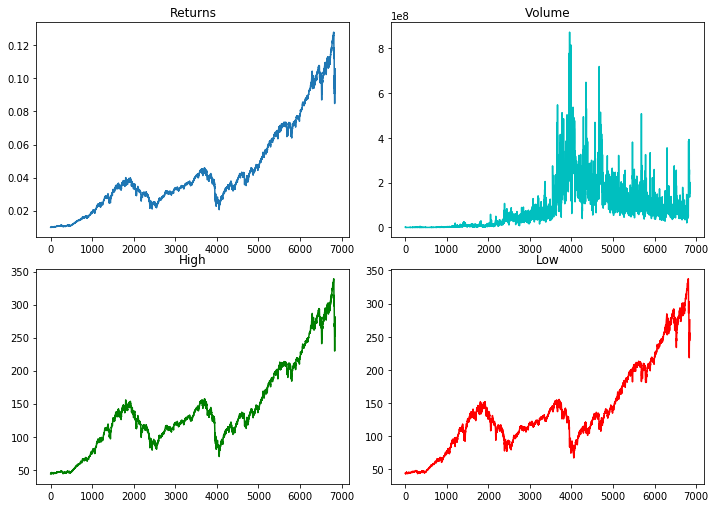

In [10]:
fig, ax = plt.subplots(2,2, figsize=(10,7))
fig.tight_layout()
ax[0][1].plot(spy.Volume, color='c')
ax[0][1].set_title("Volume");

ax[0][0].plot(spy.adj_close/spy.adj_close[0]/100);
ax[0][0].set_title("Returns");

ax[1][1].plot(spy.Low, color='r')
ax[1][1].set_title("Low");

ax[1][0].plot(spy.High, color='g')
ax[1][0].set_title("High");

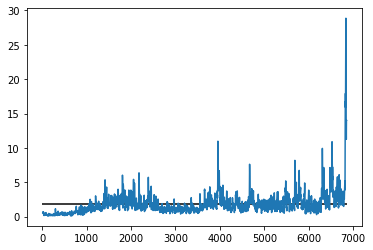

In [11]:
plt.plot(spy.Close.rolling(14).std())
np.mean(spy.Close.rolling(14).std())
plt.hlines(np.mean(spy.Close.rolling(14).std()),0,len(spy))

In [12]:
def std_dev_percentile(x,window):
    x=x.rolling(window).std().dropna().values
    #print(x)
    val=x[-1:]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val


In [13]:
std_dev_percentile(spy.adj_close[-500:],10)

(94.5, array([10.6822818]))

In [14]:
def return_percentile_latest(x,window):
    x=x/x.shift(window)-1
    x=x.dropna().values
    val=x[-1]
    return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val

def return_percentile(x,window,val):
    x=x/x.shift(window)-1
    x=x.dropna()
    return np.percentile(x,val)

def get_percentile(x, t='latest',val=0):
    if t=='latest':
        x=x.dropna().values
        val=x[-1]
        return np.round(100*(np.where(np.sort(x)==val)[0][0]/len(x)),2),val
    else:
        return  np.percentile(np.sort(x),val)
        

In [15]:
return_percentile_latest(spy.adj_close,3)#returns percentile and latest value, shift doesn't include current pos
#return_percentile(spy.adj_close,3,1.6)

(99.12, 0.05036633600957141)

### RSI

In [16]:
def RSI(series, period=14):
 print(len(series))
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / pd.stats.moments.ewma(d, com=period-1, adjust=False)
 rs = pd.Series.ewm(u, com=period-1).mean()/pd.Series.ewm(d, com=period-1).mean()
 return 100 - 100 / (1 + rs)

In [17]:
#spy.Close.rolling(14).apply(RSI, raw=False)
#Graph
#min max, %s 
#fit 14 vs 10
#backtested profitability


In [18]:
rsi=RSI(spy.adj_close).dropna();

6849


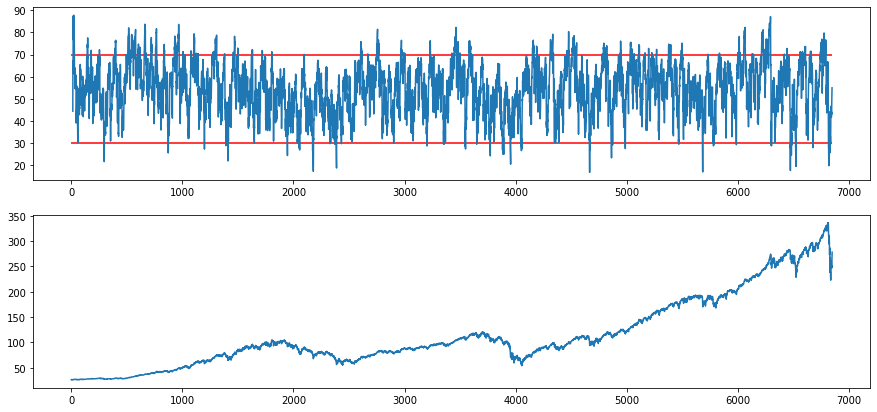

In [19]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(rsi)
ax[0].hlines(70,0,len(spy), color='red')
ax[0].hlines(30,0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [20]:
print("Min RSI", np.min(rsi))
print("Max RSI", np.max(rsi))
print("Median RSI", np.median(rsi))
print("Std dev. RSI", np.std(rsi))
print("% of time below 20", np.round(100*np.sum(np.where(rsi<20,1,0))/len(rsi),2))
print("% of time below 30", np.round(100*np.sum(np.where(rsi<30,1,0))/len(rsi),2))
print("% of time above 70", np.round(100*np.sum(np.where(rsi>70,1,0))/len(rsi),2))
print("% of time above 80", np.round(100*np.sum(np.where(rsi>80,1,0))/len(rsi),2))

Min RSI 16.80273123264722
Max RSI 87.83215691745701
Median RSI 55.61850769371372
Std dev. RSI 11.386467911661477
% of time below 20 0.13
% of time below 30 1.48
% of time above 70 8.51
% of time above 80 0.57


In [21]:
rsi.describe()

count    6835.000000
mean       54.898375
std        11.387301
min        16.802731
25%        46.799056
50%        55.618508
75%        63.304414
max        87.832157
Name: adj_close, dtype: float64

### MACD

In [22]:
macd=spy.adj_close.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()-spy.adj_close.ewm(span=26,min_periods=0,adjust=True,ignore_na=True).mean()

In [23]:
signal=macd.ewm(span=12,min_periods=0,adjust=True,ignore_na=True).mean()
macd_hist=macd-signal

In [24]:
macd_hist.describe()

count    6849.000000
mean       -0.009076
std         0.574585
min        -7.631611
25%        -0.209799
50%         0.002403
75%         0.212706
max         6.835720
Name: adj_close, dtype: float64

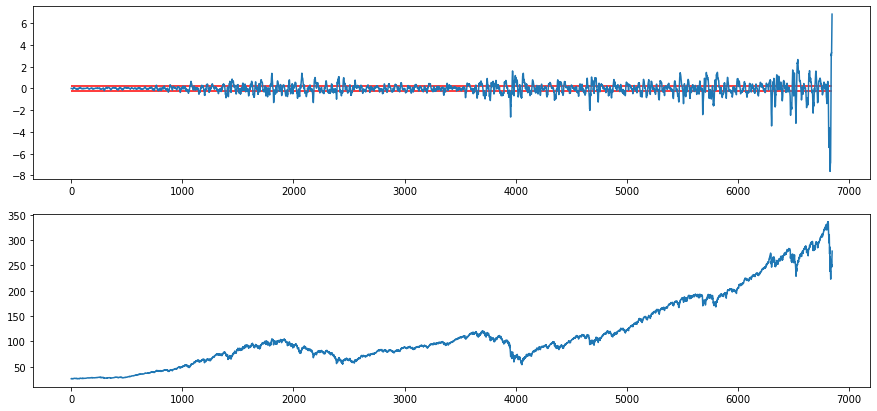

In [25]:
fig, ax= plt.subplots(2,1, figsize=(15,7))
ax[0].plot(macd_hist)
ax[0].hlines(np.percentile(macd_hist,75),0,len(spy), color='red')
ax[0].hlines(np.percentile(macd_hist,25),0,len(spy), color='red')
ax[1].plot(spy.adj_close);

In [26]:
spy['macd']=macd
spy['macd_hist']=macd_hist

In [27]:
dspy['macd']=macd
dspy['macd_hist']=macd_hist

In [28]:
def calcs(x):
    print(x)
    return 0

In [29]:
spy.macd[0]=-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [31]:
def sign_change(x):
    if np.sign(x[0]) == np.sign(x[1]):
        return False
    return True

In [32]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if sign_change([last,row.macd]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.macd>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [33]:
#On sign change buy and below -x sell:
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=row.macd
        continue
    if has_position and row.macd<=-0.2:
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            
    elif last<0 and row.macd>=0:
            has_position=True
            position_start_index=index
            if row.macd>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.macd                 

In [34]:
def calc_returns(x):
    if x.is_long==True:
        return np.round(100*(x.exit_price/x.entry_price-1),2)
    return -1*np.round(100*(x.exit_price/x.entry_price-1),2)

In [35]:
#results['returns']=np.round(100*(results.exit_price/results.entry_price-1),2)
results['returns']=results.apply(calc_returns, axis=1)

In [36]:
#results.sort_values(by='returns', ascending=False)
results

,start_date,end_date,entry_price,exit_price,is_long,returns
0,1993-02-01,1993-02-16,26.486324,26.018700,True,-1.77
1,1993-02-16,1993-03-02,26.018700,26.897835,False,-3.38
2,1993-03-02,1993-04-06,26.897835,26.573824,True,-1.20
3,1993-04-06,1993-04-15,26.573824,27.024878,False,-1.70
4,1993-04-15,1993-04-20,27.024878,26.780556,True,-0.90
...,...,...,...,...,...,...
309,2018-07-06,2018-10-10,265.957367,269.954987,True,1.50
310,2019-01-17,2019-05-14,256.564514,277.725281,True,8.25
311,2019-06-12,2019-08-05,282.615387,279.489685,True,-1.11
312,2019-09-05,2019-10-03,293.276093,287.309692,True,-2.03


In [37]:
results.returns.describe()

count    314.000000
mean       0.070191
std        5.318815
min      -10.220000
25%       -2.747500
50%       -1.295000
75%        0.967500
max       33.500000
Name: returns, dtype: float64

In [38]:
value_trend=[1000]
for r in results.returns:
    value_trend.append(value_trend[-1]*(1+r/100))

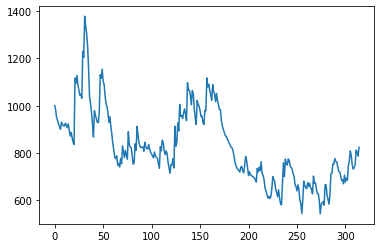

In [39]:
plt.plot(value_trend)

In [40]:
print(f'Returns (%) :', np.round(100*(value_trend[-1]/value_trend[0]-1)))
print(f'SPY returns (%) :', np.round(100*(spy.adj_close[-1:]/spy.adj_close[0]-1)))

Returns (%) : -18.0
SPY returns (%) : 6848    958.0
Name: adj_close, dtype: float64


In [41]:
macd_pos=spy.macd[spy.macd>=0]
macd_pos.describe()

count    4656.000000
mean        0.885092
std         0.753805
min         0.000121
25%         0.310830
50%         0.707401
75%         1.262029
max         4.651392
Name: macd, dtype: float64

In [42]:
macd_neg=spy.macd[spy.macd<=0]
macd_neg.describe()

count    2193.000000
mean       -1.103891
std         1.891795
min       -23.449347
25%        -1.277810
50%        -0.631479
75%        -0.239072
max        -0.000462
Name: macd, dtype: float64

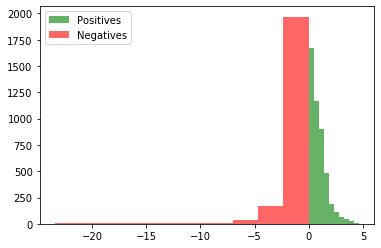

In [43]:
plt.hist(macd_pos, bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(macd_neg, bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

In [44]:
get_percentile(macd_neg,t='val',val=10)

-2.365465799849053

In [45]:
get_percentile(macd_neg)

(2.74, -4.460047394359265)

In [46]:
# macd turning point
#slopes
#value at stage of cycle
# cycle leegth vs depth 

In [47]:
macd_results=pd.DataFrame(columns=['start_date','end_date','is_long','hist','length'])

In [48]:
#### MACD values per cycle
w_macd=[]
cycle_macd_hist=[]
counter=1
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.iterrows():
    if  index == 0:
        last=-1#row[index+1].macd_hist
        continue
    if sign_change([last,row.macd_hist]):
        #print(index)
        if has_position:
            #has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            macd_results=macd_results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'is_long':is_long,'hist':cycle_macd_hist,'length':counter-1}, ignore_index=True)
            counter=1
            if has_position:
                position_start_index=index
                cycle_macd_hist=[]
                cycle_macd_hist.append(row.macd_hist)
                w_macd.append(counter*row.macd_hist)
                counter+=1
                if row.macd_hist>0:
                    is_long=True
                else:
                    is_long=False
                    
        
        else:
            has_position=True
            position_start_index=index
            w_macd.append(counter*row.macd_hist)
            counter+=1
            cycle_macd_hist.append(row.macd_hist)
            if row.macd_hist>0:
                is_long=True
            else:
                is_long=False
            
    elif has_position:
        cycle_macd_hist.append(row.macd_hist)
        w_macd.append(counter*row.macd_hist)
        counter+=1
    last=row.macd_hist                 

In [49]:
macd_results

,start_date,end_date,is_long,hist,length
0,1993-02-01,1993-02-12,True,"[0.0019233135683750886, 0.0029353020989389793,...",9
1,1993-02-12,1993-02-26,False,"[-0.0045860291755022466, -0.0396778294975153, ...",9
2,1993-02-26,1993-03-22,True,"[0.012624890656333147, 0.019272711462453948, 0...",16
3,1993-03-22,1993-04-16,False,"[-0.005791281859065564, -0.014243113186095335,...",18
4,1993-04-16,1993-04-20,True,"[0.0036131835023729825, 0.00047856660874114054]",2
...,...,...,...,...,...
515,2020-01-07,2020-01-09,False,"[-0.05148256050640221, -0.05992622412837578]",2
516,2020-01-09,2020-01-24,True,"[0.051480903590881866, 0.02675927907370479, 0....",10
517,2020-01-24,2020-02-10,False,"[-0.032798894459397765, -0.6129618253449123, -...",11
518,2020-02-10,2020-02-24,True,"[0.17271535359909995, 0.3346935061122953, 0.54...",9


In [50]:
w_macd=np.asarray(w_macd)
w_macd[-1:]

array([68.35719697])

In [51]:
np.percentile(w_macd[w_macd<=0],0.5)

-46.925074918127315

### STO

In [234]:
d={'function': 'STOCH','apikey':"YEUC2DL0F7KC43PB",'symbol':'SPY','interval':'daily','fastkperiod':10 }
response = requests.get(
        'https://www.alphavantage.co/query',
        params=d,
        )

#https://www.alphavantage.co/query?function=STOCH&symbol=SPY&interval=weekly&apikey=YEUC2DL0F7KC43PB&fastkperiod=16

In [235]:
slowk=[]
slowd=[]
for key, val in response.json()['Technical Analysis: STOCH'].items():
    slowk.append(float(val['SlowK']))
    slowd.append(float(val['SlowD']))

In [236]:
sto=pd.DataFrame({'Date':list(response.json()['Technical Analysis: STOCH'].keys()),
                 'k':slowk,
                  'd':slowd
                 })

In [237]:
sto=sto.astype({'Date': 'datetime64'})

In [238]:
spy=spy.merge(sto,left_on='Date',right_on='Date',how='left')

In [239]:
spy['sto_diff']=spy['k']-spy['d']

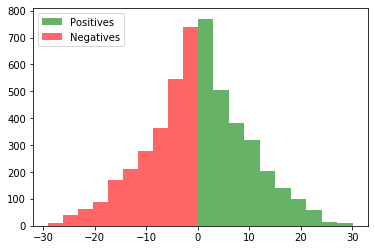

In [240]:
plt.hist(spy.sto_diff[spy.sto_diff>=0], bins=10, alpha=0.6, color='g' ,label='Positives')
plt.hist(spy.sto_diff[spy.sto_diff<=0], bins=10, alpha=0.6, color='r' ,label='Negatives')
plt.legend(loc='upper left');

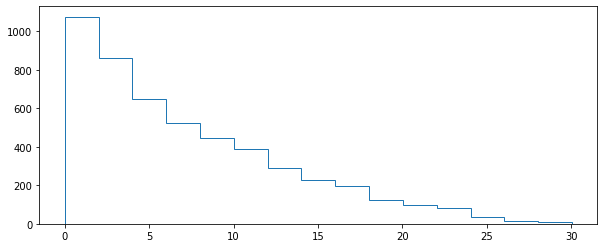

In [241]:
plt.figure(figsize=(10,4))
plt.hist(np.abs(spy.sto_diff), bins=15, histtype='step');

In [168]:
get_percentile(np.abs(spy.sto_diff.dropna()),t='val',val=10)

0.6069999999999993

In [171]:
get_percentile(spy.sto_diff.dropna(),t='val',val=1)

-18.755091000000004

In [196]:
get_percentile(spy.sto_diff[spy.sto_diff>=0].dropna(),t='val',val=99)

19.69468099999996

In [242]:
get_percentile(spy.sto_diff)

(63.94, 2.695700000000002)

In [228]:
spy.dropna().head(5)

,Date,Open,High,Low,Close,adj_close,Volume,macd,macd_hist,k_x,d_x,sto_diff,std,k_y,d_y
1847,2000-05-23,140.4375,140.8125,137.562500,138.00000,94.551285,7979200,-0.740127,-0.261113,21.7521,36.6001,-14.8480,2.752918,23.9190,39.4654
1848,2000-05-24,138.0000,140.6875,136.500000,140.25000,96.092865,11081500,-0.784629,-0.258597,21.7289,26.4806,-4.7517,2.815898,23.7758,29.1043
1849,2000-05-25,140.6875,141.8125,137.718750,137.84375,94.444168,8278900,-0.942074,-0.352036,16.6973,20.0594,-3.3621,2.799059,18.2444,21.9797
1850,2000-05-26,138.8125,139.6875,137.328125,138.00000,94.551285,4814000,-1.046147,-0.385938,18.0325,18.8196,-0.7871,2.830538,19.5914,20.5372
1851,2000-05-30,140.0000,142.9375,139.468750,142.50000,97.634476,5362700,-0.869812,-0.177356,24.5170,19.7489,4.7681,2.712847,26.2767,21.3708


In [243]:
results=pd.DataFrame(columns=['start_date','end_date','entry_price','exit_price','is_long'])

In [244]:
#On sign change.
has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if sign_change([last,row.sto_diff]):
        #print(index)
        if has_position:
            #has_position=False 
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
        
        else:
            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
            
                           
    last=row.sto_diff

In [205]:
def close_position(x,is_long):
    if is_long and x> -6.80:
        return False
    elif ~is_long and x<0:
        return True
    return True

In [220]:
#On sign change buy and below -x sell:

has_position=False
position_start_index=-1
position_end_index=-1
last=0
is_long=False
for index, row in spy.dropna().iterrows():
    if  index == 1847:
        last=row.sto_diff
        continue
    if has_position and row.sto_diff<-6.8:#close_position(row.sto_diff,is_long):
        #print(index)
        #if has_position:
            has_position=False #Uncommented for long only
            #print(last, row.macd, index)
            results=results.append({'start_date':spy.loc[position_start_index,'Date'],'end_date':spy.loc[index,'Date'],'entry_price':spy.loc[position_start_index,'adj_close'],'exit_price':spy.loc[index,'adj_close'],'is_long':is_long}, ignore_index=True)
            if has_position:
                position_start_index=index
                if row.sto_diff>0:
                    is_long=True
                else:
                    is_long=False
            
    elif ~has_position and last<0 and row.sto_diff>=0:# and index<=1852:

            has_position=True
            position_start_index=index
            if row.sto_diff>0:
                is_long=True
            else:
                is_long=False
                         
    last=row.sto_diff
                               

In [245]:
results['returns']=results.apply(calc_returns, axis=1)

In [246]:
results#.tail(20)

,start_date,end_date,entry_price,exit_price,is_long,returns
0,2000-05-05,2000-05-08,98.341011,97.602333,False,0.75
1,2000-05-08,2000-05-10,97.602333,94.636948,True,-3.04
2,2000-05-10,2000-05-12,94.636948,97.848541,False,-3.39
3,2000-05-12,2000-05-18,97.848541,98.233986,True,0.39
4,2000-05-18,2000-05-30,98.233986,97.634476,False,0.61
...,...,...,...,...,...,...
1298,2020-03-18,2020-03-19,238.596985,239.103989,False,-0.21
1299,2020-03-19,2020-03-20,239.103989,228.800003,True,-4.31
1300,2020-03-20,2020-03-24,228.800003,243.149994,False,-6.27
1301,2020-03-24,2020-04-01,243.149994,246.149994,True,1.23


In [247]:
results.returns.describe()

count    1303.000000
mean       -0.140721
std         2.160454
min        -7.840000
25%        -1.170000
50%        -0.380000
75%         0.535000
max        20.540000
Name: returns, dtype: float64

In [248]:
v=1000
value_trend=[]
for r in results.returns:
    value_trend.append(v*(1+r/100))
    v=value_trend[-1]

In [249]:
v

118.53441582523666

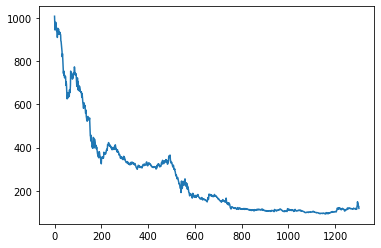

In [250]:
plt.plot(value_trend)

### Slope

In [59]:
np.polyfit(x=[1,2,3,4],y=spy.adj_close.values[-4:],deg=1,full=False)

array([  4.8920075, 258.3249815])

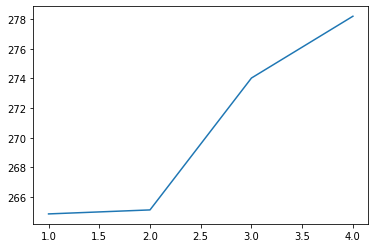

In [60]:
plt.plot([1,2,3,4],spy.adj_close.values[-4:])

In [61]:
spy['std']=spy.Close.rolling(22).apply(np.std, raw=False)

In [62]:
spy=spy.set_index('Date')

In [63]:
spy.reset_index(inplace=True)

#price drop, macd hist trough, macd level itself, vol, instead of AMCS signal cycle maybe holding cycle with <-0.3
There will be bad signals, have to make yourown determination
is down x% is what percentile of all x days, maybe VaR*
Not trade high vol situations
does it always cycle down
can repeat with weekly & sto but maybe have to rely on *
pressure release, mean reversion need of the process

so looks like forget predictor, there is not even a good descriptor for quick changes. 
Maybe use vol to describe market, explore shorter MAs for high vol. 
A lot if your skill and estimation.
sentiment maybe something from an unbiased or differentiated source 
stay long buy protection
